In [1]:
import sys
sys.path.append( '../Model/' )
from torch_geometric.datasets.sbm_dataset import StochasticBlockModelDataset
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.utils import to_networkx
import networkx as nx
from vq_vae import *
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling

In [2]:
K = 10
torch.manual_seed(2000)
size = torch.randint(10,15,(K,))
# size = torch.tensor([10,10,10,10])
mat = torch.ones((K,K)) * 0.1
mat = mat.fill_diagonal_(0.9) 
g = nx.stochastic_block_model(size.numpy(), mat.numpy(), seed=0)
a = nx.Graph()
a.add_edges_from(g.edges)
data = from_networkx(a)
l = 0
label = torch.tensor([])
for i in range(size.shape[0]):
    label = torch.cat([label, i*torch.ones((1,size[i]), dtype=torch.int)], dim=1) # real label
label = label.reshape(-1)
label = label.to(torch.int16)
print(g.number_of_nodes()) # 1377
# Fix negative edges
neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=torch.sum(size)*10)
torch.save(neg_edge_index, "data//edge_neg_large")
neg_edge_index = torch.load("data//edge_neg_large") 

124


In [3]:
def train_plot_model(prior_beta, beta, lr, epochs=1000):
    hidden_dim = 64
    latent_dim = 64
    num_latent = 30
    prior_alpha  = 1
    input_dim = 15
    torch.manual_seed(2000)
    # Initial data
    data.x = torch.randn(sum(size),input_dim)
    # model
    torch.manual_seed(2000)
    model = sb_vq_vae(input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta)

    # move to GPU (if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)

    def train(epoch):
        model.train()
        latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = model(x, edge_index, neg_edge_index=neg_edge_index)
        optimizer.zero_grad()
        loss =   recon_loss +   kl_prior1_loss  + vq_loss # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
        loss.backward()
        optimizer.step()
        # for name, params in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        # for name, parma in model.named_parameters():
        #     print(name, eval('model.'+name).grad, parma.shape)
        return float(loss), latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss

    loss_min = torch.tensor([100000]) 
    rec = []
    prior_rec = []
    recon_rec = []
    vq_loss_rec = []

    for epoch in range(1, epochs + 1):
        loss, latent_embedding, quantized_latents, codebook, recon_loss, kl_prior1_loss, pi, v, vq_loss = train(epoch)
        rec.append(loss)
        prior_rec.append(float(kl_prior1_loss))
        recon_rec.append(float(recon_loss))
        vq_loss_rec.append(float(vq_loss))
        # for name, param in model.named_parameters():
        #     print(name, eval('model.'+name).grad)
        if loss < loss_min:
            loss_min = loss
            model.eval()
            latent_embedding_min, quantized_latents_min, codebook_min, recon_loss_min, kl_prior1_loss_min, pi_min, v_min, vq_loss_min = model(x, edge_index, neg_edge_index=neg_edge_index)

        if epoch % 100 == 0:
            print('Epoch:{:03d}, loss:{:.4f}'.format(epoch, loss))
            # print(quantized_latents[0,:])
            # for p in model.parameters():
            #     print(p[:,0])
    plt.plot(prior_rec)
    plt.plot(recon_rec)
    plt.plot(vq_loss_rec)
    model.eval()
    _, color = torch.unique(torch.sum(torch.round(quantized_latents_min, decimals=4), dim=1), return_inverse=True)
    return prior_rec, recon_rec, vq_loss_rec, color
    
def purity(color, label):
    pur = torch.zeros(torch.max(color)+1, torch.max(label)+1)
    for i in range(torch.max(color)+1):
        for j in range(torch.max(label)+1):
            pur[i,j] = torch.sum((color==i) & (label==j)) / torch.sum(color==i)
    return pur



In [4]:
lr=1e-2
epochs=1000

/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Epoch:100, loss:4.4924
Epoch:200, loss:3.1818
Epoch:300, loss:3.1065
Epoch:400, loss:3.0117
Epoch:500, loss:2.9636
Epoch:600, loss:2.9470
Epoch:700, loss:2.9396
Epoch:800, loss:2.9396
Epoch:900, loss:2.9395
Epoch:1000, loss:2.9394
tensor([[0.4286, 0.1071, 0.0714, 0.0714, 0.0000, 0.0357, 0.0714, 0.1071, 0.0714,
         0.0357],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000,
         0.0000],
        [0.0357, 0.1429, 0.1786, 0.0714, 0.1429, 0.1071, 0.0714, 0.1071, 0.1071,
         0.0357],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.0000, 0.0000, 0.0000,
         0.2500],
        [0.0000, 0.1667, 0.0833, 0.2500, 0.1667, 0.0833, 0.0000, 0.0833, 0.0833,
         0.0833],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

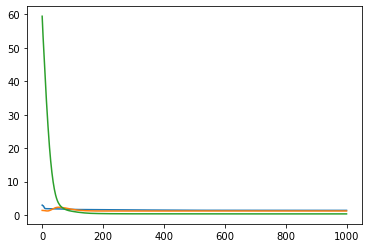

In [5]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=0.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:4.0398
Epoch:200, loss:2.9885
Epoch:300, loss:2.8384
Epoch:400, loss:2.8011
Epoch:500, loss:2.7850
Epoch:600, loss:2.7894
Epoch:700, loss:2.7755
Epoch:800, loss:2.7828
Epoch:900, loss:2.7736
Epoch:1000, loss:2.7128
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2857, 0.1429, 0.1429, 0.1429,
         0.2857],
        [0.0000, 0.0417, 0.0833, 0.1250, 0.2083, 0.1667, 0.1250, 0.0000, 0.0833,
         0.1667],
        [0.0357, 0.1786, 0.1429, 0.0714, 0.1429, 0.0714, 0.0714, 0.1071, 0.1071,
         0.0714],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000, 0.0000,
         0.0000],
        [0.0000, 0.1667, 0.3333, 0.0000, 0.0000, 0.0000, 0.1667, 0.3333, 0.0000,
         0.0000],
        [0.0000, 0.2143, 0.0714, 0.1429, 0.0000, 0.0714, 0.1429, 0.2143, 0.0

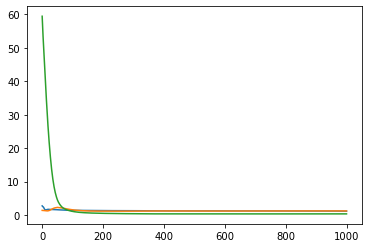

In [6]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:4.3455
Epoch:200, loss:2.6065
Epoch:300, loss:2.3381
Epoch:400, loss:2.2832
Epoch:500, loss:2.2784
Epoch:600, loss:2.2677
Epoch:700, loss:2.2575
Epoch:800, loss:2.2263
Epoch:900, loss:2.2246
Epoch:1000, loss:2.2248
tensor([[0.6316, 0.0526, 0.1053, 0.0000, 0.0526, 0.0526, 0.0526, 0.0526, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1429, 0.2857, 0.0000, 0.1429, 0.1429, 0.2857, 0.0000,
         0.0000],
        [0.0000, 0.2273, 0.1364, 0.1818, 0.0455, 0.0909, 0.0000, 0.1364, 0.0909,
         0.0909],
        [0.0500, 0.1500, 0.0500, 0.0500, 0.1500, 0.1000, 0.1500, 0.1000, 0.0500,
         0.1500],
        [0.0000, 0.0625, 0.0000, 0.0625, 0.1250, 0.0625, 0.1250, 0.1250, 0.2500,
         0.1875],
        [0.0000, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.1212, 0.0606, 0.0606,
         0.1515],
        [0.0000, 0.0000, 0.1429, 0.0000, 0.1429, 0.0000, 0.1429, 0.1429, 0.4286,
         0.0000]])
tensor(6)
0.7620602250099182 1.2600071430206299 0.20278136432170868


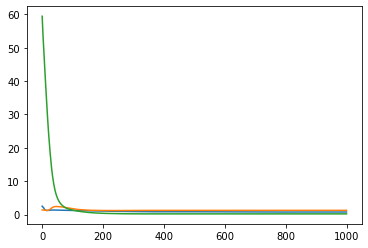

In [7]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=1.5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:4.2342
Epoch:200, loss:2.6824
Epoch:300, loss:2.4487
Epoch:400, loss:2.3566
Epoch:500, loss:2.3385
Epoch:600, loss:2.3384
Epoch:700, loss:2.2430
Epoch:800, loss:2.2308
Epoch:900, loss:2.2302
Epoch:1000, loss:2.2298
tensor([[0.0000, 0.1111, 0.1111, 0.1111, 0.1667, 0.2222, 0.0556, 0.0000, 0.0000,
         0.2222],
        [0.0000, 0.0000, 0.0556, 0.1111, 0.1111, 0.1667, 0.1667, 0.1111, 0.1111,
         0.1667],
        [0.0000, 0.0833, 0.0833, 0.0000, 0.1667, 0.0000, 0.1667, 0.1667, 0.2500,
         0.0833],
        [0.0000, 0.1786, 0.0714, 0.2143, 0.0714, 0.0714, 0.0357, 0.1786, 0.1071,
         0.0714],
        [0.0909, 0.2727, 0.1818, 0.0909, 0.1818, 0.0909, 0.0909, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0833, 0.0833, 0.1667, 0.0833, 0.3333,
         0.2500],
        [0.6667, 0.0556, 0.1111, 0.0000, 0.0000, 0.0556, 0.0556, 0.0556, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.2857, 0.0

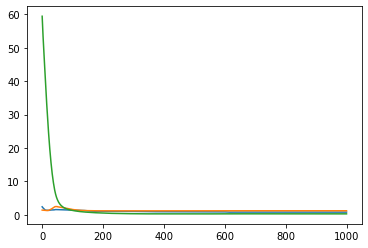

In [8]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=2, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:3.4705
Epoch:200, loss:2.4859
Epoch:300, loss:2.1627
Epoch:400, loss:2.0656
Epoch:500, loss:2.0429
Epoch:600, loss:2.0358
Epoch:700, loss:2.0354
Epoch:800, loss:2.0358
Epoch:900, loss:2.0361
Epoch:1000, loss:2.0358
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
         0.6667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000,
         0.0000],
        [0.5000, 0.0000, 0.2143, 0.0714, 0.0000, 0.0000, 0.1429, 0.0714, 0.0000,
         0.0000],
        [0.4545, 0.0909, 0.0000, 0.0000, 0.0909, 0.1818, 0.0000, 0.1818, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
         0.5000],
        [0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0

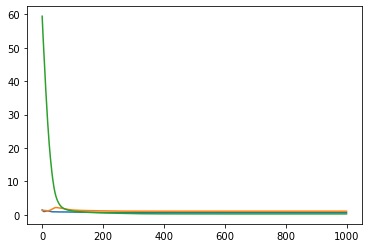

In [9]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=5, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:3.2702
Epoch:200, loss:2.3640
Epoch:300, loss:2.0331
Epoch:400, loss:1.9071
Epoch:500, loss:1.8799
Epoch:600, loss:1.8753
Epoch:700, loss:1.8741
Epoch:800, loss:1.8729
Epoch:900, loss:1.8727
Epoch:1000, loss:1.8732
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0909, 0.0909, 0.0000, 0.1818, 0.0000, 0.0909, 0.1818, 0.2727,
         0.0909],
        [0.0000, 0.1818, 0.0909, 0.0909, 0.0000, 0.0909, 0.0909, 0.2727, 0.0909,
         0.0909],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
         0.5000],
        [0.0000, 0.1111, 0.0000, 0.2222, 0.2222, 0.1111, 0.2222, 0.0000, 0.0000,
         0.1111],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0

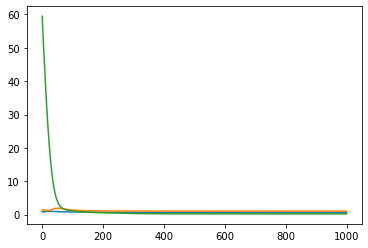

In [10]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:3.3009
Epoch:200, loss:2.4561
Epoch:300, loss:2.1987
Epoch:400, loss:2.0637
Epoch:500, loss:1.9951
Epoch:600, loss:1.9616
Epoch:700, loss:1.9488
Epoch:800, loss:1.9371
Epoch:900, loss:1.9364
Epoch:1000, loss:1.9366
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.1000, 0.0000, 0.0000,
         0.0000],
        [0.2857, 0.1429, 0.4286, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
         0.0000],
        [0.0000, 0.3750, 0.1250, 0.0000, 0.0000, 0.0000, 0.1250, 0.1250, 0.1250,
         0.1250],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
         0.0000],
        [0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.0

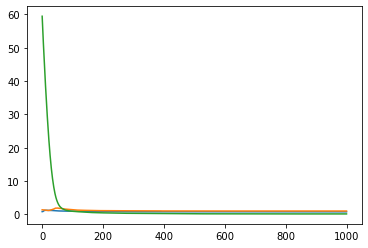

In [11]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=20, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[len(prior_rec)-1], recon_rec[len(prior_rec)-1], vq_loss_rec[len(prior_rec)-1])

Epoch:100, loss:4.3558
Epoch:200, loss:3.3652
Epoch:300, loss:3.1351
Epoch:400, loss:3.0067
Epoch:500, loss:2.9508
Epoch:600, loss:2.9274
Epoch:700, loss:2.9263
Epoch:800, loss:2.9256
Epoch:900, loss:2.9252
Epoch:1000, loss:2.9251
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.2857, 0.1429, 0.1429, 0.0000, 0.0000, 0.1429, 0.1429, 0.0000,
         0.1429],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6000, 0.0000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.4000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000,
         0.4000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0

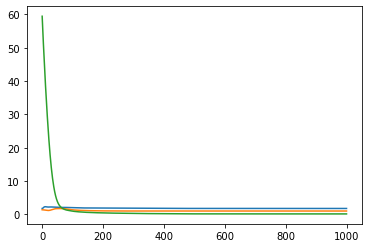

In [12]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=100, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])

Epoch:100, loss:5.9397
Epoch:200, loss:5.1963
Epoch:300, loss:4.9103
Epoch:400, loss:4.7993
Epoch:500, loss:4.7412
Epoch:600, loss:4.7161
Epoch:700, loss:4.7083
Epoch:800, loss:4.7044
Epoch:900, loss:4.7030
Epoch:1000, loss:4.7022
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1111, 0.2222, 0.1111, 0.1111, 0.2222, 0.1111, 0.1111, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.0000, 0.2857, 0.0000,
         0.1429],
        [0.0000, 0.3333, 0.0000, 0.1667, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667,
         0.0000],
        [0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3333, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

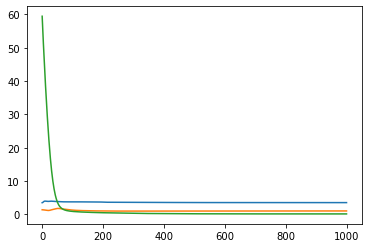

In [13]:
prior_rec, recon_rec, vq_loss_rec, color = train_plot_model(prior_beta=10000, beta=0.25, lr=lr, epochs=epochs)
print(purity(color, label))
print(torch.max(color))
print(prior_rec[epochs-1], recon_rec[epochs-1], vq_loss_rec[epochs-1])